In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

##데이터 준비

In [ ]:
# 1. 데이터 로드
def load_dataset(data_path):
    dataset = []
    labels = []
    for person_id, person_dir in enumerate(os.listdir(data_path)):
        person_path = os.path.join(data_path, person_dir)
        if os.path.isdir(person_path):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)
                dataset.append(img_path)
                labels.append(person_id)
    return dataset, labels

# 2. 쌍 생성 함수
def create_image_pairs(dataset, labels, num_pairs_same, num_pairs_diff):
    same_pairs = []
    diff_pairs = []
    label_to_indices = {}

    # 라벨 별 인덱스 그룹화
    for idx, label in enumerate(labels):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)

    # 동일 인물 쌍 생성
    for _ in range(num_pairs_same):
        label = random.choice(list(label_to_indices.keys()))
        idx1, idx2 = random.sample(label_to_indices[label], 2)
        same_pairs.append((dataset[idx1], dataset[idx2], 1))  # Label: 1 (Same)

    # 다른 인물 쌍 생성
    unique_labels = list(label_to_indices.keys())
    for _ in range(num_pairs_diff):
        label1, label2 = random.sample(unique_labels, 2)
        idx1 = random.choice(label_to_indices[label1])
        idx2 = random.choice(label_to_indices[label2])
        diff_pairs.append((dataset[idx1], dataset[idx2], 0))  # Label: 0 (Different)

    return same_pairs + diff_pairs

# 3. 데이터셋 생성
def prepare_image_pairs(data_path, num_pairs_same=200, num_pairs_diff=200):
    dataset, labels = load_dataset(data_path)
    pairs = create_image_pairs(dataset, labels, num_pairs_same, num_pairs_diff)
    random.shuffle(pairs)
    return pairs


# 4. TF 데이터셋 변환
def create_tf_dataset(pairs, image_size=(112, 112)):  # ArcFace에 맞게 (112, 112)로 설정
    def preprocess(img1_path, img2_path, label):
        # 이미지 로드 및 전처리
        img1 = tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(img1_path), channels=3),
            image_size
        ) / 255.0
        img2 = tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(img2_path), channels=3),
            image_size
        ) / 255.0

        # label을 float32로 변환
        label = tf.cast(label, tf.float32)
        return (img1, img2), label

    # Dataset 생성
    img1_paths = [pair[0] for pair in pairs]
    img2_paths = [pair[1] for pair in pairs]
    labels = [pair[2] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img1_paths, img2_paths, labels))
    dataset = dataset.map(
        lambda img1_path, img2_path, label: tf.py_function(
            preprocess, [img1_path, img2_path, label],
            (tf.float32, tf.float32)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset



In [ ]:
# 사용 예제
data_path = '/content/drive/MyDrive/Colab Notebooks/cropped_faces'  # 데이터 디렉토리 경로
# pairs = prepare_image_pairs(data_path)


In [ ]:
'''data = []
labels = []
for pair in pairs:
  img1_path, img2_path, label = pair
  img1 = tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(img1_path), channels=3),
            (112,112)
        ) / 255.0
  img2 = tf.image.resize(
      tf.image.decode_jpeg(tf.io.read_file(img2_path), channels=3),
      (112,112)
  ) / 255.0

  data.append([img1, img2])
  labels.append(label)'''

'data = []\nlabels = []\nfor pair in pairs:\n  img1_path, img2_path, label = pair\n  img1 = tf.image.resize(\n            tf.image.decode_jpeg(tf.io.read_file(img1_path), channels=3),\n            (112,112)\n        ) / 255.0\n  img2 = tf.image.resize(\n      tf.image.decode_jpeg(tf.io.read_file(img2_path), channels=3),\n      (112,112)\n  ) / 255.0\n\n  data.append([img1, img2])\n  labels.append(label)'

In [ ]:
dataset, labels = load_dataset(data_path)
datas = []
for p in dataset:
  datas.append(tf.image.resize(
            tf.image.decode_jpeg(tf.io.read_file(p), channels=3),
            (112,112)
        ) / 255.0)
#datas = datas[:-2]
#labels = labels[:-2]

In [ ]:
# img1_list = []
# img2_list = []
# for d in data:
#   img1_list.append(d[0])
#   img2_list.append(d[1])

In [ ]:
#with open('/content/drive/MyDrive/Colab Notebooks/image_pairs.pkl', 'rb') as f:
#  pair_path = pickle.load(f)

##데이터셋 준비

In [ ]:
num_classes = 4
num_samples = 418
input_shape = (112,112,3)

In [ ]:
train_data, validation_data, train_label, validation_label = train_test_split(datas, labels, test_size = 2/13, shuffle = True)

In [ ]:
datas = np.array(train_data, dtype=np.float32)
labels = np.array(tf.cast(train_label, dtype=tf.int32))
val_datas = np.array(validation_data, dtype=np.float32)
val_labels = np.array(tf.cast(validation_label, dtype=tf.int32))

In [ ]:
print('train:', len(datas))
print('validation:', len(val_datas))

train: 353
validation: 65


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((datas, labels))
dataset = dataset.map(
    lambda x, y: ({"input_image": x, "input_labels": tf.cast(y, tf.int32)}, tf.cast(y, tf.int32))
)  # 모델 입력 형태 맞추기
dataset = dataset.batch(16).shuffle(100)

In [ ]:
# val_dataset 생성
val_dataset = tf.data.Dataset.from_tensor_slices((val_datas, val_labels))

# 데이터를 모델에 맞는 형태로 변환
val_dataset = val_dataset.map(
    lambda x, y: ({"input_image": x, "input_labels": tf.cast(y, tf.int32)}, tf.cast(y, tf.int32))
)

# 배치 크기 및 셔플
val_dataset = val_dataset.batch(16).shuffle(100)

##모델 준비

In [ ]:
import cv2
import numpy as np
#import insightface
#from insightface.app import FaceAnalysis
#from insightface.data import get_image as ins_get_image
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def arcface_loss(embedding, labels, num_classes, s=64.0, m=0.5):
    # 가중치는 함수 외부에서 정의 및 초기화
    weights = tf.Variable(
        tf.random.normal([embedding.shape[1], num_classes]), trainable=True, name="arcface_weights"
    )
    weights = tf.nn.l2_normalize(weights, axis=0)  # Normalize weights

    def loss_fn(labels, embeddings):
        # Normalize embeddings
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)

        # Compute logits
        logits = tf.matmul(embeddings, weights)

        # Apply ArcFace margin
        one_hot = tf.one_hot(labels, depth=num_classes)
        theta = tf.acos(tf.clip_by_value(logits, -1.0, 1.0))
        margin_logits = tf.cos(theta + m)

        # Scale logits
        logits = logits * (1 - one_hot) + margin_logits * one_hot
        logits *= s

        # Compute loss
        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits))

    return loss_fn


In [ ]:
class ArcFaceLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, embedding_dim, s=64.0, m=0.5):
        super(ArcFaceLayer, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.s = s
        self.m = m

    def call(self, embeddings, labels, weights):
        # Normalize embeddings and weights
        embeddings = tf.nn.l2_normalize(embeddings, axis=1)
        weights = tf.nn.l2_normalize(weights, axis=0)

        # Compute logits (similarity score between embeddings and weights)
        logits = tf.matmul(embeddings, weights)

        # Apply ArcFace margin
        one_hot = tf.one_hot(labels, depth=self.num_classes)
        theta = tf.acos(tf.clip_by_value(logits, -1.0, 1.0))
        margin_logits = tf.cos(theta + self.m)

        # Scale logits
        logits = logits * (1 - one_hot) + margin_logits * one_hot
        logits *= self.s

        return logits

##모델 구축

In [ ]:
embedding_dim = 128
num_classes = 4  # 실제 데이터셋에 맞게 수정

In [ ]:
inputs = tf.keras.layers.Input(shape=(112, 112, 3), name="input_image")
labels = tf.keras.layers.Input(shape=(), dtype=tf.int32, name="input_labels")

In [ ]:
# Backbone
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(inputs)
x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(x)
x = tf.keras.layers.Flatten()(x)
embedding = tf.keras.layers.Dense(embedding_dim, activation="relu")(x)

# ArcFace Layer
weights = tf.Variable(tf.random.normal([embedding_dim, num_classes]), trainable=True)

arcface_logits = ArcFaceLayer(num_classes, embedding_dim)(embedding, labels, weights)

# Final Model
model = tf.keras.Model(inputs=[inputs, labels], outputs=arcface_logits)


##학습

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history = model.fit(dataset, epochs=10, validation_data = val_dataset, batch_size = 16)

##결과 확인

In [ ]:
# 훈련 후 History 객체에서 loss, accuracy 확인
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

#print("Training Loss:", loss)
#print("Training Accuracy:", accuracy)
#print("Validation Loss:", val_loss)
#print("Validation Accuracy", val_accuracy)

In [ ]:
epochs = range(1, len(loss) + 1)  # epoch 번호

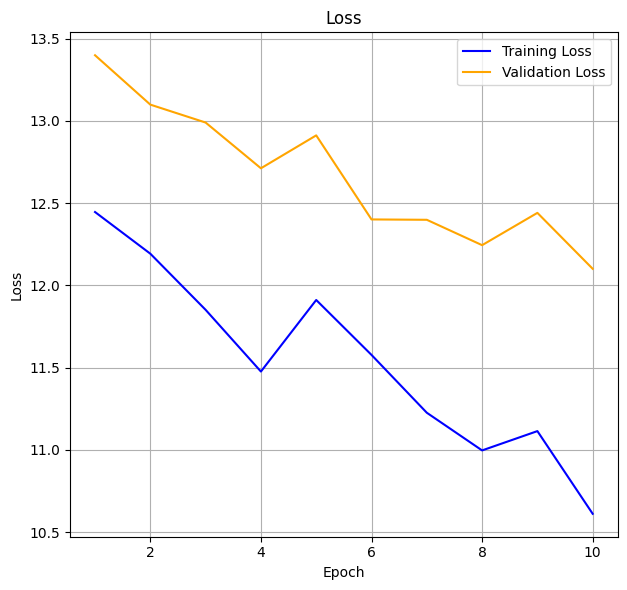

In [ ]:
import matplotlib.pyplot as plt

# Loss 그래프
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy 그래프
'''
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()'''

# 그래프 보여주기
plt.tight_layout()
plt.show()